In [ ]:
import torch as T
import torch.nn as nn
import numpy as np

In [ ]:
device = 'cuda' if T.cuda.is_available() else 'cpu'

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Generator, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=9, padding=4, bias=False)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=3, padding=1, bias=False)
    self.prelu = nn.PReLU()
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.pixshuff = nn.PixelShuffle(2)
    self.output = nn.Conv2d(out_channels, in_channels, kernel_size=9, padding=4, bias=False) 


  def block(self):
    return nn.Sequential(
        self.conv2,
        self.batchnorm,
        self.prelu,
    )
  
  def input_block(self):
    return nn.Sequential(
        self.conv1,
        self.prelu,
    )

  def output_block(self):
    return nn.Sequential(
        self.conv3,
        self.pixshuff,
        self.prelu
    )

  def forward(self, x):
    block_in = self.input_block()(x)
    block1 = T.add(self.block()(block_in), block_in)
    block2 = T.add(self.block()(block1), block1)
    block3 = T.add(self.block()(block2), block2)
    block4 = T.add(self.block()(block3), block3)
    block_bridge = T.add(block4, block_in)
    block5 = self.output_block()(block_bridge)
    block6 = self.output_block()(block5)
    output = self.output(block6)
    return output

In [ ]:
generator = Generator(3, 64).to(device)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels, out_channels, units):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.conv1_1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels * 2, kernel_size=3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(out_channels * 2, out_channels * 2, kernel_size=3, stride=2, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(out_channels * 2)
    self.conv4 = nn.Conv2d(out_channels * 2, out_channels * 4, kernel_size=3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(out_channels * 4, out_channels * 4, kernel_size=3, stride=2, padding=1, bias=False)
    self.batchnorm3 = nn.BatchNorm2d(out_channels * 4)
    self.conv6 = nn.Conv2d(out_channels * 4, out_channels * 8, kernel_size=3, padding=1, bias=False)
    self.conv7 = nn.Conv2d(out_channels * 8, out_channels * 8, kernel_size=3, stride=2, padding=1, bias=False)
    self.batchnorm4 = nn.BatchNorm2d(out_channels * 8)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.conv8 = nn.Conv2d(out_channels * 8, out_channels * 16, kernel_size=1)
    self.batchnorm5 = nn.BatchNorm2d(out_channels * 16)
    self.out_conv = nn.Conv2d(out_channels * 16, 1, kernel_size=1)
    self.sigmoid = nn.Sigmoid()
    self.leakyrelu = nn.LeakyReLU(0.2)

  def block(self):
    return nn.Sequential(
        self.conv2,
        self.batchnorm2,
        self.leakyrelu,
        self.conv3,
        self.batchnorm2,
        self.leakyrelu,
        self.conv4,
        self.batchnorm3,
        self.leakyrelu,
        self.conv5,
        self.batchnorm3,
        self.leakyrelu,
        self.conv6,
        self.batchnorm4,
        self.leakyrelu,
        self.conv7,
        self.batchnorm4,
        self.leakyrelu,
    )

  def input_block(self):
    return nn.Sequential(
        self.conv1,
        self.leakyrelu,
        self.conv1_1,
        self.batchnorm1,
        self.leakyrelu,
    )

  def out_block(self):
    return nn.Sequential(
        self.conv8,
        self.batchnorm5, 
        self.leakyrelu,
        self.pool,
        self.out_conv,
        self.sigmoid
    )

  def forward(self, x):
    block_in = self.input_block()(x)
    x = self.block()(block_in)
    output = self.out_block()(x)
    return output

In [ ]:
discriminator = Discriminator(3, 64, 1024).to(device)

In [ ]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, dataset
from torchvision.datasets import ImageFolder
import cv2
from PIL import Image

class ConcatDataset(T.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

BATCH_SIZE = 16
SIZE_HR = 256
SIZE_LR = 64
num_workers = 2
rootpath = './data'
transform_hr = transforms.Compose([
                                transforms.Resize((SIZE_HR, SIZE_HR)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

data_hr = ImageFolder(rootpath, transform=transform_hr)

In [ ]:
transform_lr = transforms.Compose([
                                  transforms.Resize((SIZE_LR, SIZE_LR)), 
                                  transforms.ToTensor(),
                                  transforms.GaussianBlur(kernel_size=25),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

data_lr = ImageFolder(rootpath, transform=transform_lr)

In [ ]:
full_data = ConcatDataset(data_lr, data_hr)
loader = DataLoader(full_data, BATCH_SIZE, num_workers=num_workers)

In [ ]:
sample = next(iter(loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


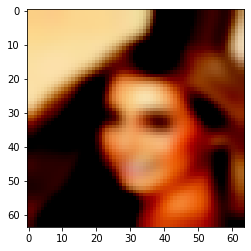

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


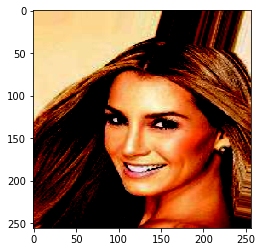

In [ ]:
import matplotlib.pyplot as plt
  
def show_image(image):
  result =  image.permute(1,2,0)
  plt.imshow(result, interpolation='nearest')
  plt.show()

show_image(sample[0][0][0])
show_image(sample[1][0][0])

In [ ]:
from torchvision import models

class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = models.vgg19(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        adversarial_loss = T.mean(1 - out_labels)
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = T.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = T.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:
import torch.optim as optim

gen_optimizer = optim.Adam(generator.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(discriminator.parameters(),lr=0.0001)

generator_criterion = GeneratorLoss().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
g_losses = []
d_losses = []

In [ ]:
def show_progress(imgs, path='generated_data', save=False, show=True):
  # Low res -> Predicted -> High res
  time = datetime.datetime.now().strftime("%m.%d__%H:%M")
  if show:
    fig, ax = plt.subplots(1, 3, figsize=(20,20))
    for idx, img in enumerate(imgs):
      img = img.permute(1,2,0)
      ax[idx].imshow(img, interpolation='nearest')
      ax[idx].axis('off')
    plt.show()
  if save:
    if path not in os.listdir():
      os.mkdir(path)
    fig, ax = plt.subplots(1, 3, figsize=(20,20))
    for idx, img in enumerate(imgs):
      img = img.permute(1,2,0)
      ax[idx].imshow(img, interpolation='nearest')
      ax[idx].axis('off')
    plt.savefig(path + '/' + f'img{time}.png')

In [ ]:
import datetime

def save(gen, disc, path):
  time = datetime.datetime.now().strftime("%m.%d__%H")
  T.save(gen.state_dict(), path + f'gen{time}.pth')
  T.save(disc.state_dict(), path + f'disc{time}.pth')

EPOCH [1/1000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 0/12663 
Loss (Generator) 0.4880373477935791
Loss (Discriminator) 1.0009276866912842


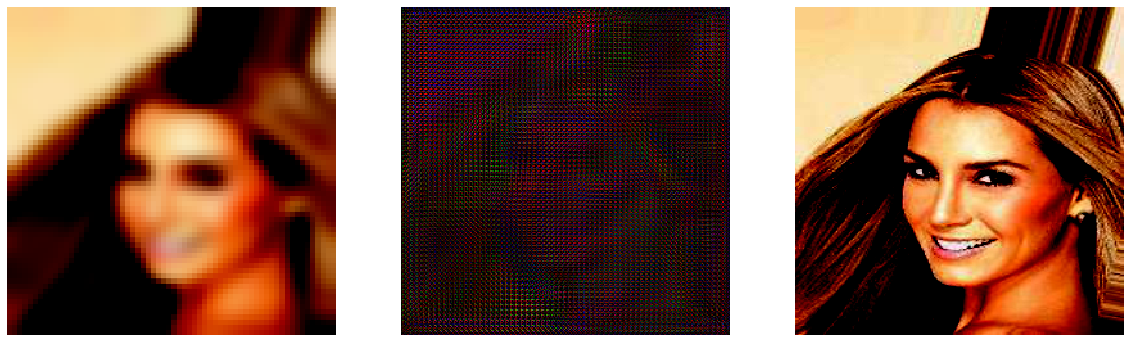

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 100/12663 
Loss (Generator) 0.10184715688228607
Loss (Discriminator) 1.0001769065856934


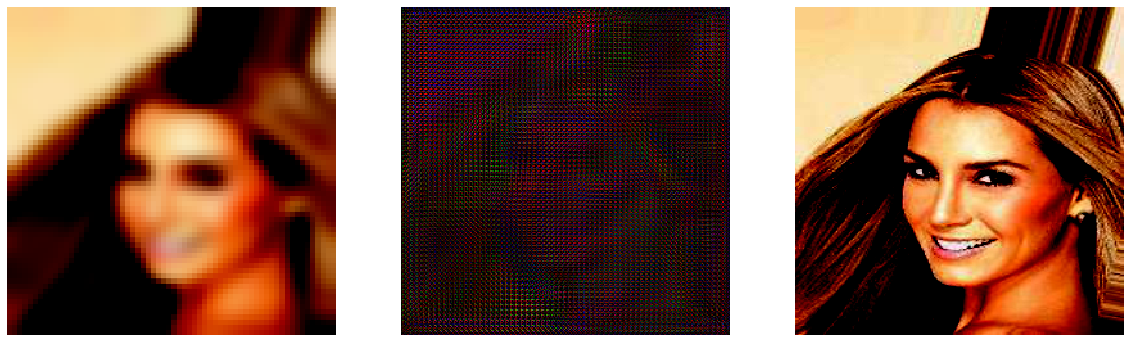

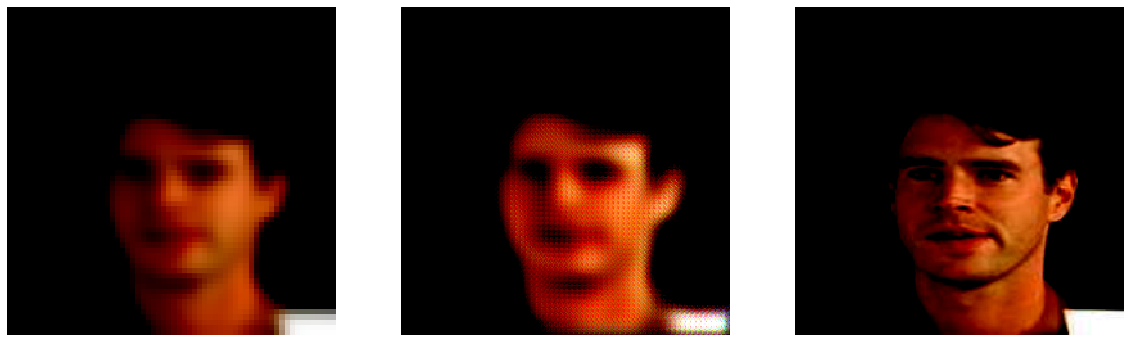

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 200/12663 
Loss (Generator) 0.0784245952963829
Loss (Discriminator) 1.0004949569702148


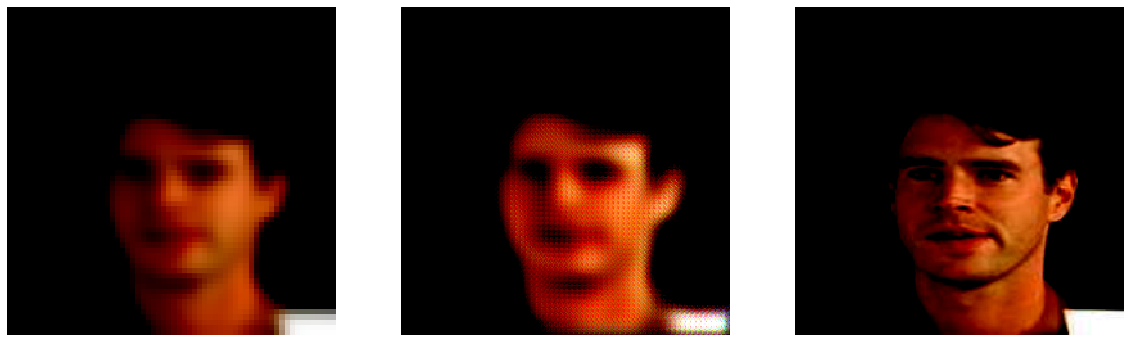

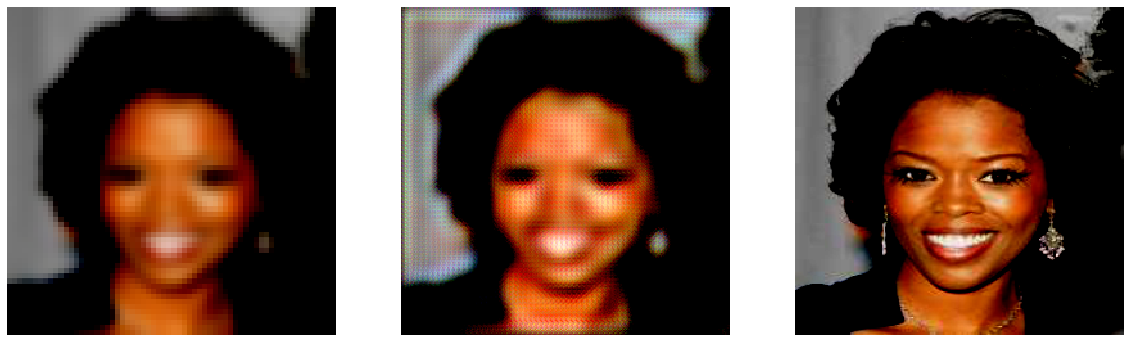

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 300/12663 
Loss (Generator) 0.059257324784994125
Loss (Discriminator) 1.000037670135498


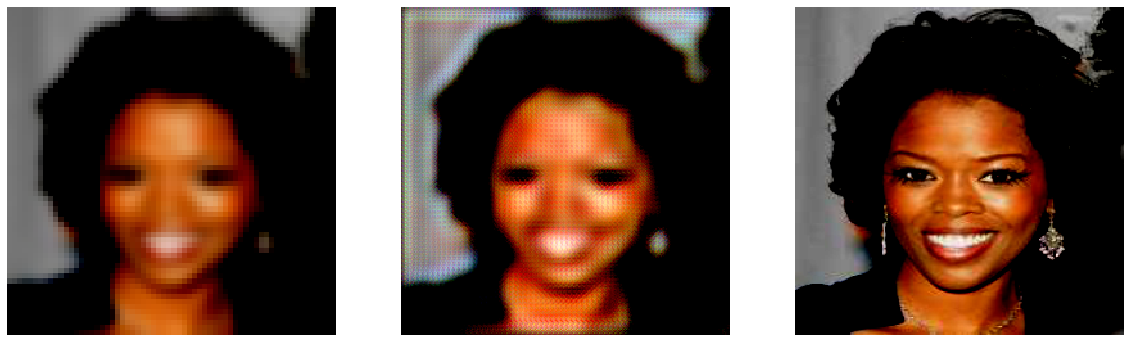

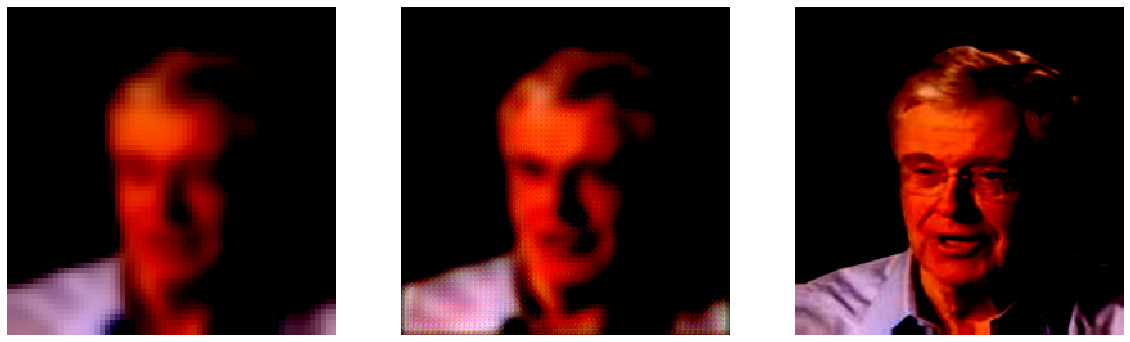

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 400/12663 
Loss (Generator) 0.05828704684972763
Loss (Discriminator) 0.9996286630630493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


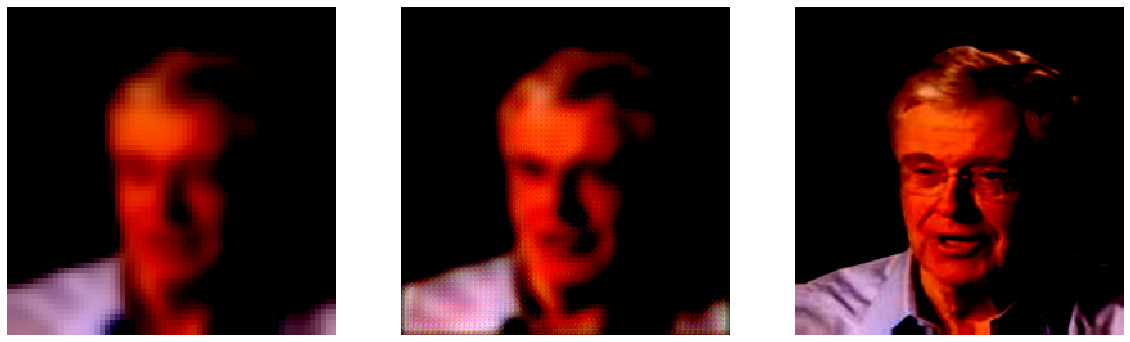

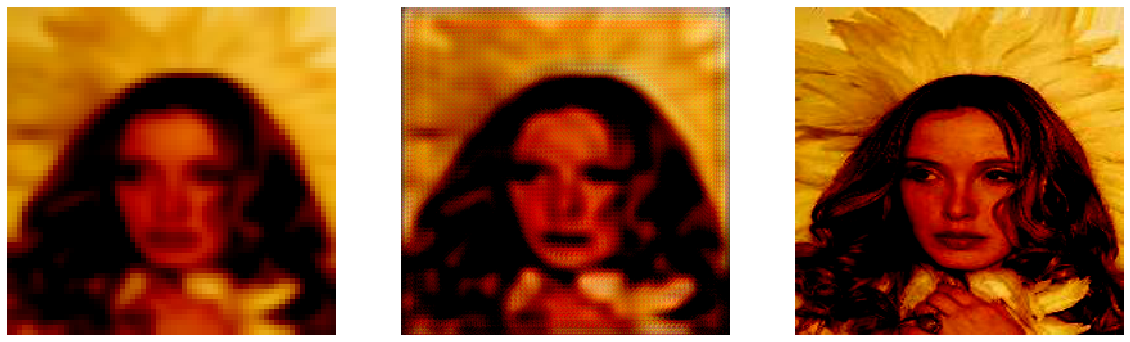

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 500/12663 
Loss (Generator) 0.05494900792837143
Loss (Discriminator) 0.999626874923706


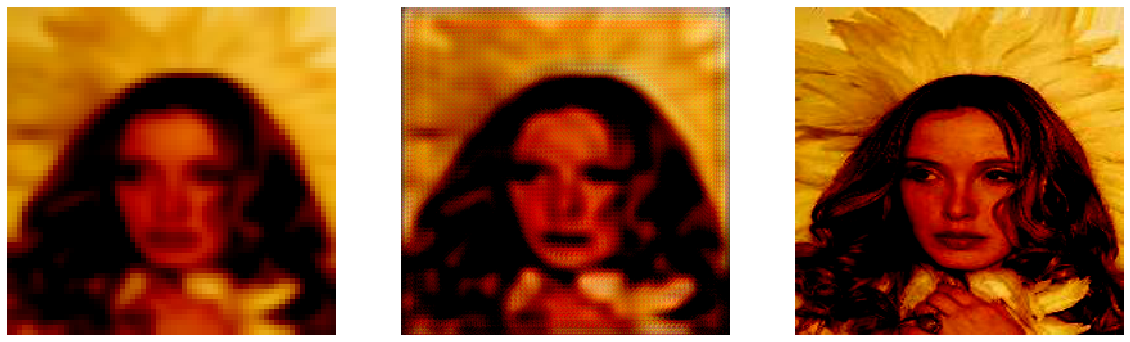

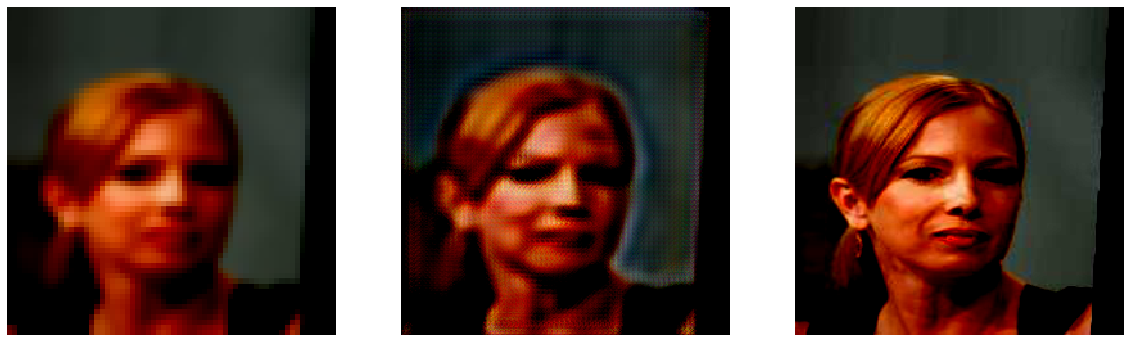

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 600/12663 
Loss (Generator) 0.053378552198410034
Loss (Discriminator) 0.999515950679779


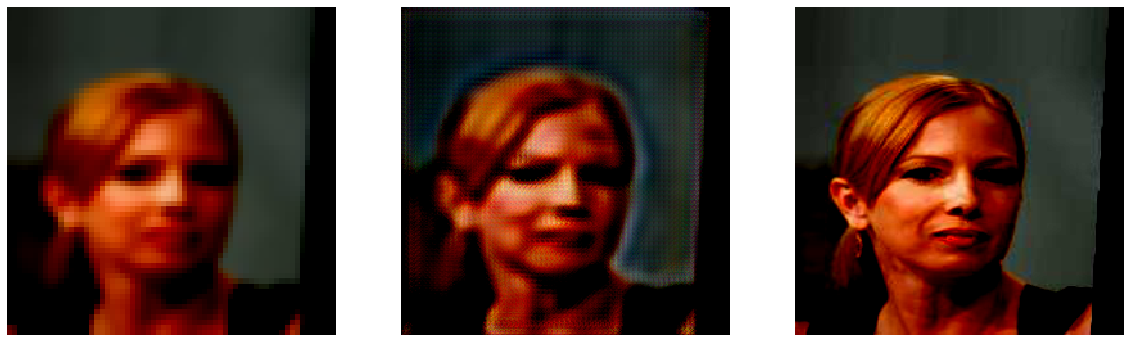

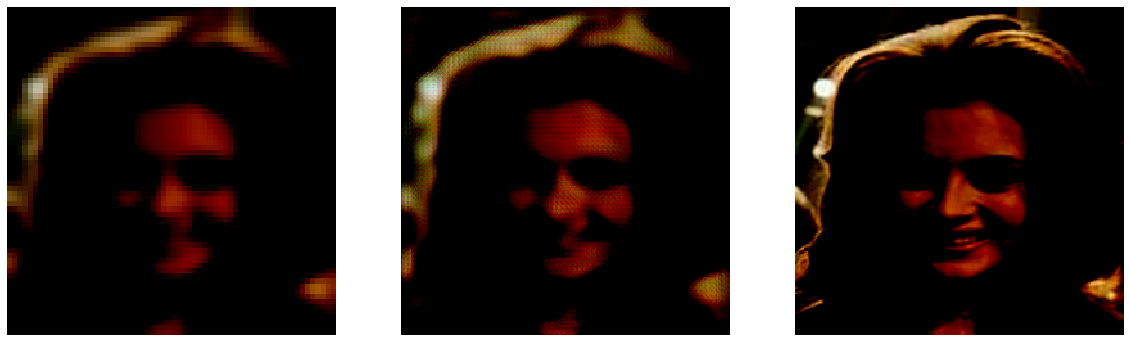

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 700/12663 
Loss (Generator) 0.0546872615814209
Loss (Discriminator) 0.9997878670692444


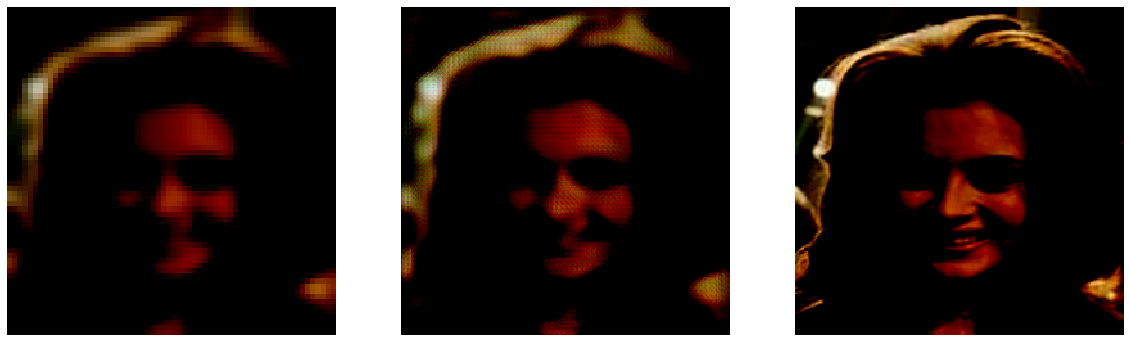

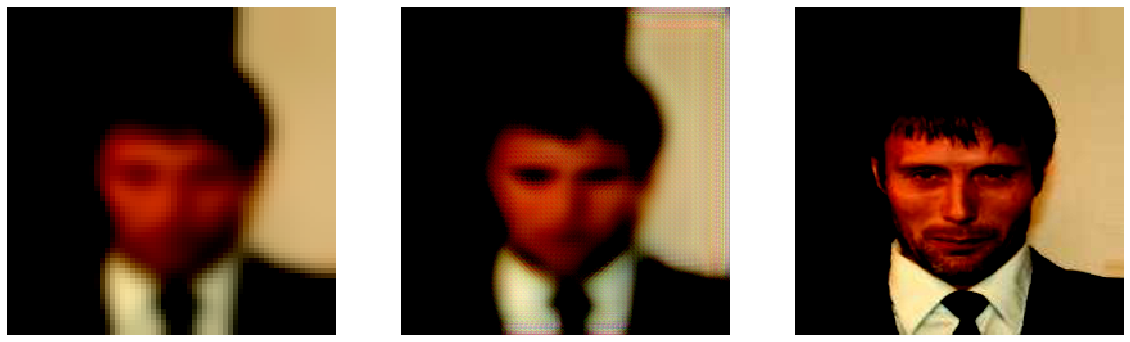

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch 800/12663 
Loss (Generator) 0.05406581610441208
Loss (Discriminator) 0.9994014501571655


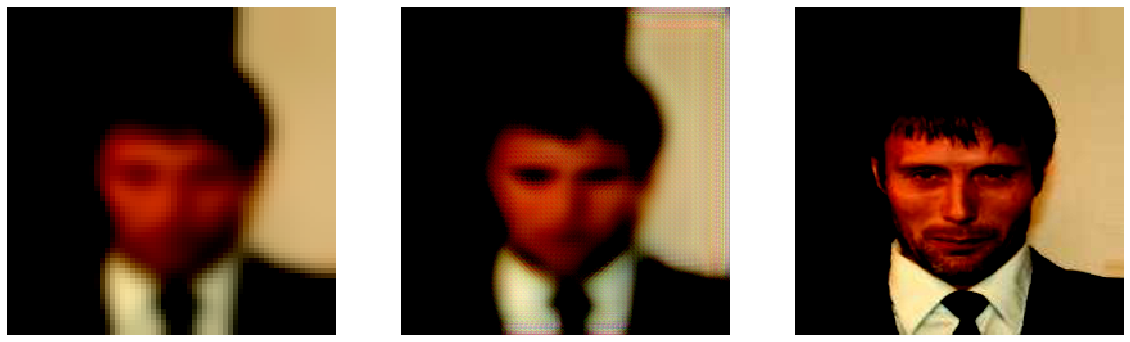

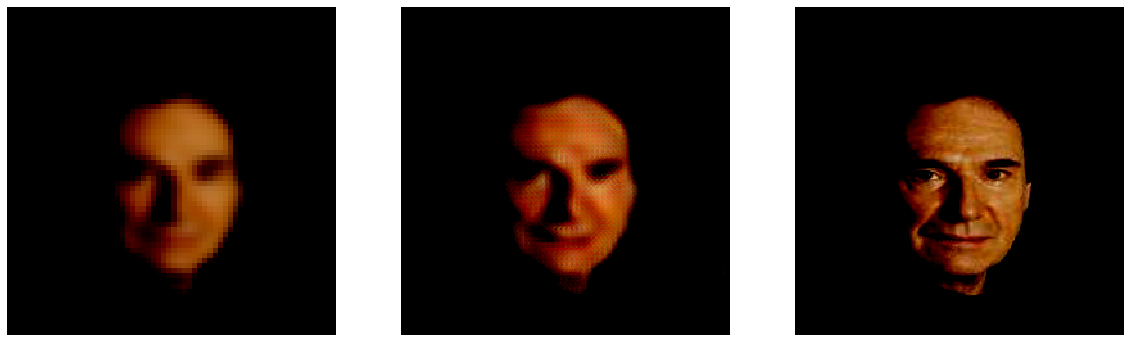

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
import gc
import os

EPOCHS = 1000
if 'models' not in os.listdir():
  os.mkdir('models')

save_path = './models/'

for epoch in range(1, EPOCHS):
  generator.train()
  discriminator.train()
  print(f'EPOCH [{epoch}/{EPOCHS}]')
  sum_d_loss = 0
  sum_g_loss = 0
  gc.collect()
  T.cuda.empty_cache()
  start = datetime.datetime.now()
  for idx, (item, target) in enumerate(loader):
    item = item[0].to(device)
    target = target[0].to(device)
    fake_image = generator(item)
    discriminator.zero_grad()
    
    real_out = discriminator(target).mean()
    fake_out = discriminator(fake_image).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph=True)

    generator.zero_grad()
    g_loss = generator_criterion(fake_out, fake_image, target)
    g_loss.backward()
    
    fake_img = generator(item)
    fake_out = discriminator(fake_img).mean()
    if idx % 100 == 0:
      print(f'Batch {idx}/{loader.__len__()} \nLoss (Generator) {g_loss.detach().cpu()}\nLoss (Discriminator) {d_loss.detach().cpu()}')
      pred = fake_img[0].detach().cpu()
      save(generator, discriminator, save_path)
      show_progress([item.detach().cpu()[0], pred, target.detach().cpu()[0]], save=True)

    gen_optimizer.step()
    
    sum_d_loss += d_loss.detach().cpu()
    sum_g_loss += g_loss.detach().cpu()
  print(f'Time per epoch = {start - datetime.datetime.now()}')
  g_losses.append(sum_g_loss / loader.__len__())
  d_losses.append(sum_d_loss / loader.__len__())
  print(f'D_loss {sum_d_loss}')
  print(f'G_loss {sum_g_loss}')